In [1]:
import pyscf
from pyscf import gto,dft,scf

# import neuralxc
# from neuralxc.projector.pyscf import get_eri3c as get_mlovlp
import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import * 
from dpyscf.torch_routines import * 
from dpyscf.utils import *
from dpyscf.losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'eig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
DEVICE='cpu'

In [28]:
xc_pbe = get_scf('GGA','../models/pretrained/pbe_pol/',polynomial=True).xc
# xc_pbe = get_scf('GGA','../models/pretrained/pbe/',path='../exp/log_gga_2/2021-01-18_13:03:16.804040_val.chkpt').xc
x_pbe = xc_pbe.grid_models[0]
c_pbe = xc_pbe.grid_models[1]

xc = get_scf('GGA','../models/pretrained/pbe_pol/',path='../exp/log_gga_pol/2021-01-31_17:19:04.988164_val.chkpt',polynomial=True, ueg_limit=True ).xc
# xc = xc_pbe
x = xc.grid_models[0]
c = xc.grid_models[1]

Loading pre-trained models from ../models/pretrained/pbe_pol/
Loading pre-trained models from ../models/pretrained/pbe_pol/


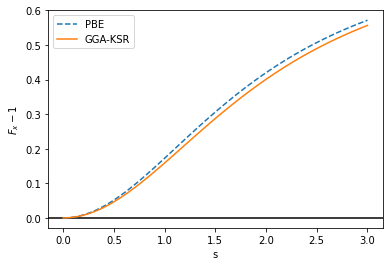

In [29]:
axhline(0,color='black')

# s = torch.exp(torch.linspace(-4,5,100).unsqueeze(-1))
# xscale('log')

s = torch.linspace(0, 3, 100).unsqueeze(-1)
# s_inp = (1-torch.exp(-s**2/xc_pbe.s_gam))*torch.log(s+1)
#     s_inp = torch.log(s + 1e-3)
rho = torch.zeros_like(s)+1

inp = torch.cat([rho,s],dim=-1)

#     plot(s, x_pbe(inp).detach().numpy(),label='alpha={}'.format(a),color='C{}'.format(idx))
#     plot(s, x(inp).detach().numpy(),label='alpha={}'.format(a),color='C{}'.format(idx),ls='-')
plot(s, x_pbe(inp).detach().numpy(),ls='--',label='PBE')
plot(s, x(inp).detach().numpy(),ls='-', label='GGA-KSR')
#     plot(s, x(inp).detach().numpy(),label='KSR')
# plot(s, 1.17*torch.sigmoid(torch.log(s)).detach().numpy())


xlabel('s')
ylabel('$F_x-1$')
legend()
# savefig('figs/Fx_gga.pdf', bbox_inches='tight')
# savefig('../figs/Fx_gga.png', bbox_inches='tight')

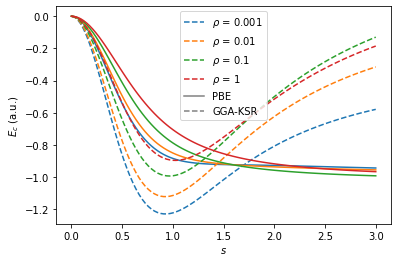

In [22]:
# for idx, rho_val in enumerate([0.001]):
# for idx, rho_val in enumerate([0.0001,0.001,0.01,0.1]):
for idx, rho_val in enumerate([0.001, 0.01,0.1,1]):
    s = torch.linspace(0,3,100)

    rho = torch.log(torch.Tensor([rho_val**(1/3)]*len(s))+xc_pbe.loge)

    inp = torch.stack([rho, rho, s, s],dim=-1)
    plot(s, c_pbe(inp).detach().numpy()[:,-2],ls='-')
    plot(s, c(inp).detach().numpy()[:,-2], label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-KSR',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
# axhline(-1)
xlabel('$s$')
ylabel('$E_c$ (a.u.)')
legend()
# savefig('figs/Ec_gga.pdf', bbox_inches='tight')
# savefig('../figs/Ec_gga.png', bbox_inches='tight')

In [23]:
xc_pbe.polynomial = True
xc.polynomial = True

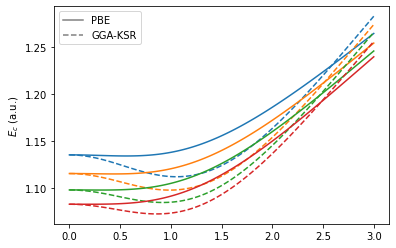

In [26]:
for idx, rho_val in enumerate([0.001, 0.01, 0.1, 1]):
    s = torch.linspace(0, 3,100)

    rho = torch.Tensor([rho_val**(1/3)]*len(s))+xc_pbe.loge
#     rho = torch.Tensor([rho_val]*len(s))
    gamma = (2*(3*np.pi**2)**(1/3)*rho**(4/3)*s)**2 * 0.25
    inp = torch.stack([rho, rho, gamma, gamma, gamma, s, s, s, s],dim=-1)
    
    plot(s, xc_pbe.eval_grid_models(inp).squeeze().detach().numpy()/xc_pbe.heg_model(2*rho).squeeze(),ls='-')
    plot(s, xc.eval_grid_models(inp).squeeze().detach().numpy()/xc_pbe.heg_model(2*rho).squeeze(),color='C{}'.format(idx),ls = '--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-KSR',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
# axhline(-1)
# xlabel('$s$')
ylabel('$E_c$ (a.u.)')
legend()

Text(0, 0.5, '$E_c$')

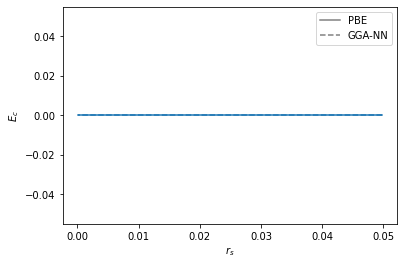

In [53]:
for idx, rho_val in enumerate([0.01]):
    s = torch.linspace(3,10,100)

    s = torch.exp(s)
    
#     s = 0
    zeta1 = torch.Tensor([0]*len(s))
    spinscale1 =torch.log(0.5*((1+zeta1)**(4/3) + (1-zeta1)**(4/3)))
    zeta2 = torch.Tensor([1]*len(s))
    spinscale2 =torch.log(0.5*((1+zeta2)**(4/3) + (1-zeta2)**(4/3)))
    rho = torch.log(s + xc.loge)
    
    inp1 = torch.stack([rho, spinscale1, torch.zeros_like(rho)],dim=-1)
    inp2 = torch.stack([rho, spinscale2, torch.zeros_like(rho)],dim=-1)
#     plot(s, c_pbe(inp).detach().numpy(),ls='-')
#     plot(s, c(inp).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
    plot(1/s, c(inp1).detach().numpy(),ls='-')
    plot(1/s, c(inp2).detach().numpy(),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-NN',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
legend()
xlabel('$r_s$')
ylabel('$E_c$')
# savefig('figs/Ec_gga_rs.pdf', bbox_inches='tight')
# savefig('../figs/Ec_gga_rs.png', bbox_inches='tight')

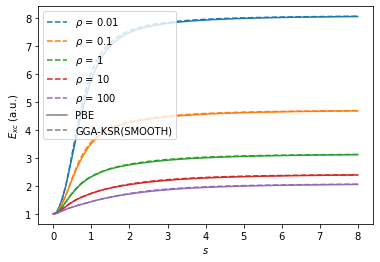

In [28]:
for idx, rho_val in enumerate([0.01,0.1,1,10,100]):
    s = torch.linspace(0, 8,100)

#     s = torch.exp(s)
    
    s_inp = (1-torch.exp(-s**2/xc.s_gam))*torch.log(s+1)
    
    zeta = torch.Tensor([0]*len(s_inp))
    spinscale =torch.log(0.5*((1+zeta)**(4/3) + (1-zeta)**(4/3)))

    rho = torch.log(torch.Tensor([rho_val**(1/3)]*len(s))+xc.loge)
    rho_pure = torch.Tensor([rho_val]*len(s))
    inp = torch.stack([rho, spinscale, s_inp],dim=-1)
    inp_x = torch.stack([rho, s_inp],dim=-1)
#     e_pbe = c_pbe(inp) + (1 + x_pbe(inp_x))*xc.heg_model(rho_pure)
#     e = c(inp) + (1 + x(inp_x))*xc.heg_model(rho_pure)
    e_pbe = (c_pbe(inp) + (1 + x_pbe(inp_x))*xc.heg_model(rho_pure))/xc.heg_model(rho_pure)
    e =  (c(inp) + (1 + x(inp_x))*xc.heg_model(rho_pure))/xc.heg_model(rho_pure)
#     e_pbe = -(1 + x_pbe(inp_x))
#     e =  -(1 + x(inp_x))
    plot(s, e_pbe.detach().numpy(),ls='-')
    plot(s, e.detach().numpy(), label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-KSR(SMOOTH)',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
xlabel('$s$')
ylabel('$E_{xc}$ (a.u.)')
legend()
# savefig('figs/Ec_gga.pdf', bbox_inches='tight')
# savefig('../figs/Ec_gga.png', bbox_inches='tight')